#  LMS Exploration |  14. 주식예측
---

**[Introduce]**  

- 삼성전자, Google, Tesla, Naver 의 주식예측을 진행해보겠습니다. 
- 시계열 예측(Time-Series Prediction)을 다루는 여러 통계적 기법 중에서 가장 널리 알려진 ARIMA(Auto-regressive Integrated Moving Average) 모델을 활용해 실제 주식값 예측을 해봅니다 (ARIMA 모델에 대한 설명은 아래에서~)
- 주식 예측을 위해서는 Stationary한 데이터가 필요합니다. 따라서 다음의 과정을 통해 데이터를 Stationary 한 시계열로 가공하여 모델을 훈련하고 테스트 하겠습니다.


    - 결측치 처리
    - 로그 변환
    - 시계열 안정성 분석
        - 정성적 그래프 분석
        - 정량적 Augmented Dicky-Fuller Test
        - 시계열 분해(Time Series Decomposition)
        - Residual 안정성 확인
    - 학습, 테스트 데이터셋 생성
    - 적정 ARIMA 모수 찾기
    - ARIMA 모델 훈련과 테스트
    
 

**[dataset]**

- [Yahoo Finance](https://finance.yahoo.com/)에서 데이터셋을 다운로드 합니다. 
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있습니다.
- 여기서는 종가(close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능한데, 종가란 하루의 장이 마감하였을 때의 가격입니다.) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# 1. 삼성전자 주식예측

## 1-1. 시계열 데이터 준비
- 데이터 파일은 Date, Open, High, Low, Close, Adj Close, Volume의 총 7개의 컬럼을 가진 cvs 파일입니다.
- 우선 pandas 의 DataFrame 자료구조로 데이터를 불러온 뒤, Date컬럼을 Index로 하고 Close (종가) 컬럼을 값으로 하는 Time Series Data로 만들어줍니다. 

In [66]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [67]:
ts1 = df['Close']
ts1.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## 1-2. 전처리
- 결측치 처리 : 시계열 데이터이므로 결측치 양옆의 값들이 이용해 적절히 보간(interpolate)하여 대입하는 방법을 선택했습니다. 
- 로그 변환 : 시간 추이에 따라 분산이 점점 커지고 있는 경우, 로그함수로 변환을 해주면 안정성이 개선됩니다. 

Series([], Name: Close, dtype: float64)


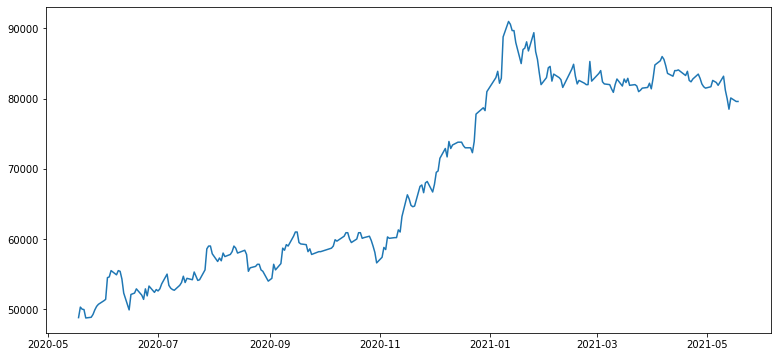

In [68]:
#- 결측치 보간
ts1 = ts1.interpolate(method='time')
print(ts1[ts1.isna()])
plt.plot(ts1)

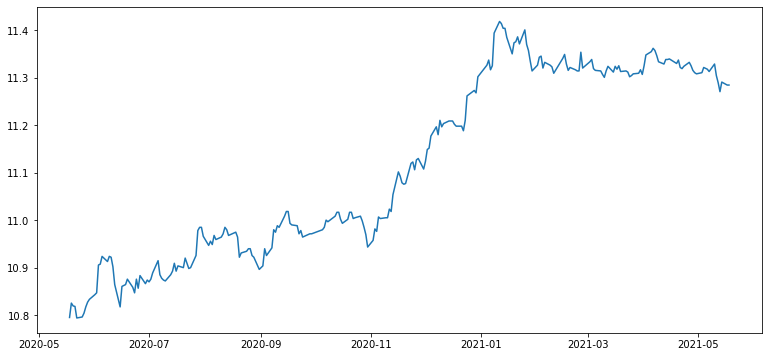

In [69]:
#- 로그 변환
ts_log = np.log(ts1)
plt.plot(ts_log)

## 1-3. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해 (Time Series Decomposition)
- Residual 안정성 확인


---

#### " 과거의 패턴이 미래에도 반복될 것이다 "
- 위의 시계열 예측의 대전제를 유지하기 위해서 필요한 조건이 바로 "시계열 데이터의 안정성" 입니다. 
- 안정적 시계열에서 시간의 추이와 관계없이 일정해야 하는 통계적 특성 세가지는 1. 평균 2. 분산 3.공분산 입니다.
- ADF Test를 통해 시계열 데이터의 안정성을 통계적으로 테스트할 수 있습니다. 
- 불안정적인 시계열을 안정적 시계열로 변형하기 위한 방법으로 다음의 두가지가 있습니다.
    1. 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도 
        - 로그함수 변환
        - Moving average 제거- 추세(Trend) 상쇄하기 
        - 차분(Differencing)- 계절성(Seasonality) 상쇄하기
    2. 시계열 분해(Time series decomposition) 기법의 적용 
        - statsmodels 라이브러리 안에 seasonal_decompose메소드
        - 위에서 직접 수행한 moving average 제거, differencing 을 거치지 않고도, 안정적인 시계열을 분리해낼 수 있음. 
        - Trend + Seasonality + Residual = Original 
        - 위와 같은 Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여줍니다. 

---

* 추세 : 시간 추이에 따라 나타나는 평균값 변화
* 계절성 : Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화

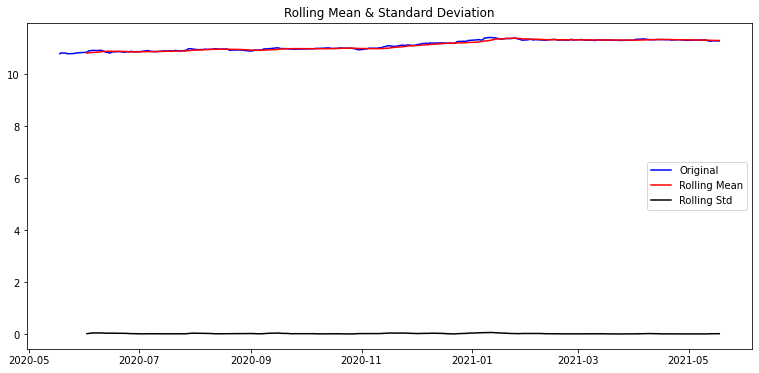

In [70]:
#- 정성적 그래프 분석

from matplotlib.pylab import rcParams

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() #- 이동평균
    rolstd = timeseries.rolling(window=window).std() #- 이동표준편차
    
    #- 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    
plot_rolling_statistics(ts_log, window=12)

- Original , Rolling Mean, Rolling Std 모두 안정적으로 보입니다. 

In [71]:
#- 정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    #- statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    #- adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- Augmented Dicky-Fuller Test 에서 대다수의 분석에서는 0.05의 알파가 유의성의 기준으로 사용됩니다. P값이 0.05 미만인 경우 평균 간에 차이가 없다는 귀무 가설을 기각하고 유의한 차이가 있다는 결론을 내리게 됩니다. P값이 0.05보다 크면 큰 차이가 존재한다는 결론을 내릴 수 없습니다.

- 위 결과에서 p-value는 0.59 를 보이는데, 이는 통계적으로 유의하지 않다고 해석될 수 있습니다. 즉 귀무가설을 기각하고 대립가설을 채택할 근거가 부족한 것입니다. 
즉, 현재의 시계열은 안정적이라고 말할 수 없습니다. 

- 다음으로는 시계열 분해를 통해, 시계열을 안정적으로 변환해보겠습니다. 

---

- 귀무가설(null hypothesis) : 우리가 증명하고자 하는 가설의 반대되는 가설, 효과와 차이가 없는 가설을 의미함. 
- 대립가설 : 연구자가 연구를 통해 입증되기를 기대하는 예상이나 주장하는 내용. 이번 사례에서는 "시계열이 안정적이다" 가 대립가설이 될 것입니다. 

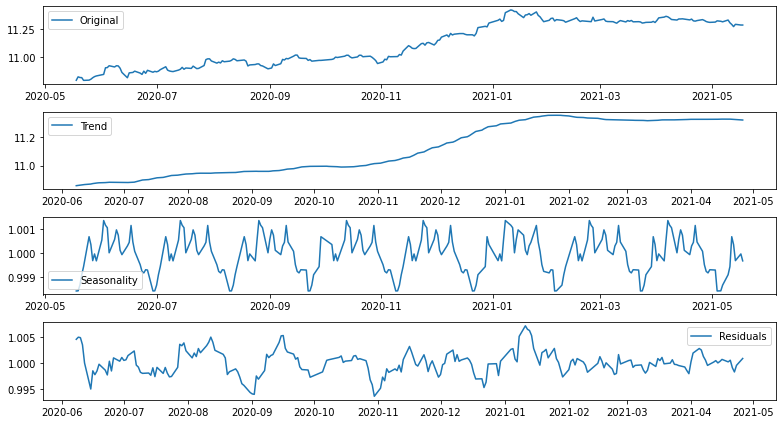

In [72]:
#- 시계열 분해 (Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend #- 추세(시간의 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal #- 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid #- 원본(로그변환) - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

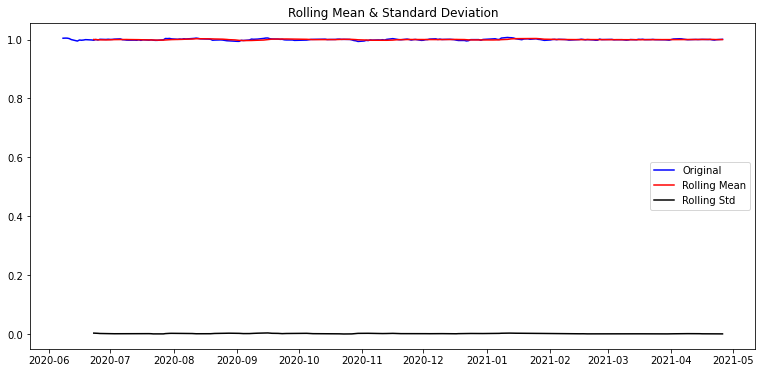

In [73]:
plt.rcParams['figure.figsize']=(13,6)
plot_rolling_statistics(residual)

In [74]:
#- residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


- Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보입니다. 
- 귀무가설을 기각하고 대립가설을 채택할 수 있을 것이라 생각됩니다. 즉, 시계열이 안정적이라 말할 수 있습니다. 

## 1-4. 학습 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리합니다. 
- 미래에 대한 주가를 예측하는 것이 목표이므로, test set은 끝부분을 사용합니다.

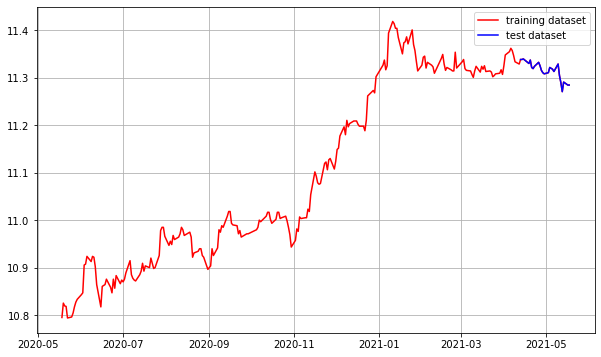

In [75]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [76]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


## 1-5. 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기


```
p : 자기회귀 모형(AR)의 시차
q : 이동평균 모형(MA)의 시차
d : 차분누적(I) 횟수
```

- 이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문.

- 적절한 모수 p, d, q를 선택하는 방법으로 많은 통계학적 시도가 있지만, 대표적으로 ACF(Autocorrelation Function) 과 PACF (Partial Autocorrelation Function)이 있습니다. 


- ACF(Autocorrelation Function) : 
    - 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
    - 주어진 시계열의 현재 값이 과거값과 어떻게 상관되는지 설명
    - ACF plot에서 X 축은 상관계수를나타냄. y축은 시차 수를 나타냄. 
 
- PACF(Partial Autocorrelation Function) :
    - 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수 
    - k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데, 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도. 
 

아래 그림은 ACF를 통해 MA 모델의 시차 q를 결정하고 PACF를 통해 AR 모델의 시차 p를 결정할 수 있음을 통계학적으로 설명하는 아티클의 요약결론 부분입니다.

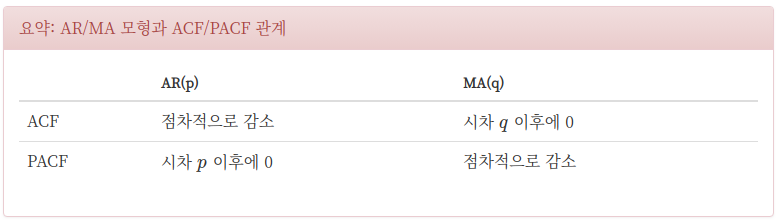

[출처 : https://datascienceschool.net]

---

#### AR 모델의 시차 p

- PACF 그래프를 볼때 p=1 이 적합한 것으로 보입니다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 의미입니다. 

#### AR 모델의 시차 q

- 반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있는데, q에 대해서는 적합한 값이 없어 보이기 때문에 MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다.

#### d차 차분

- d를 구하기 위해서 d차 차분을 구해보고 이때 시계열이 안정된 상태인지 확인해봅니다. 
앞서 Augmented Dickey-Fuller Test 를 통해 시계열 데이터의 안정성을 통계적으로 테스트 해보았습니다. 

---


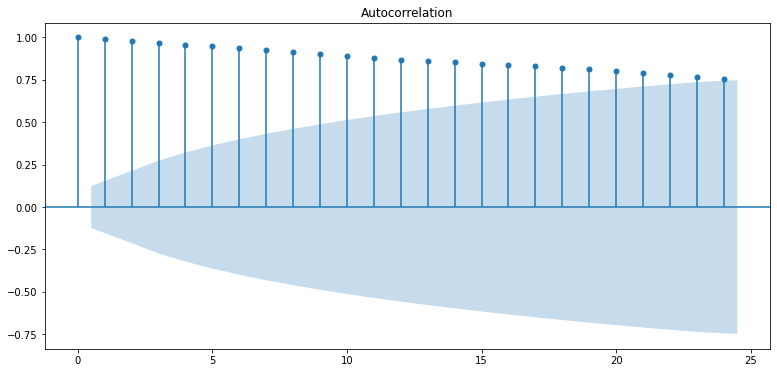

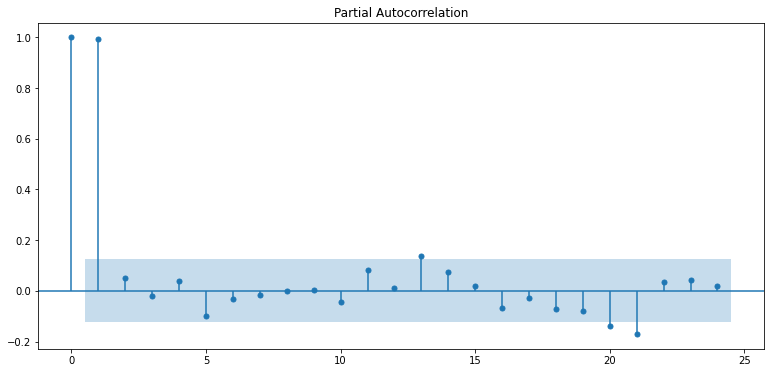

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) #- Autocorrelation 
plot_pacf(ts_log) #- Partial Autocorrelation
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


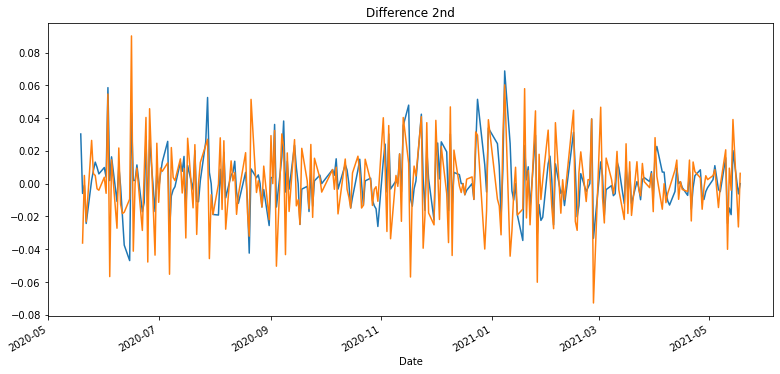

In [78]:
#- 1차 차분
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

#- 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 확인 결과 2차 차분을 진행했을 때, p-value가 오히려 증가하므로, 1차 차분까지 진행하기로 결정했습니다. (d = 1)

## 1-5. ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)
---


### ARIMA 모델 정의
ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)

- AR (자기회귀, Auto regressive)
    - '오늘은 주식이 올라서 균형을 맞추겠지?'
    - AR은 시계열의 Residual 에 해당하는 부분을 모델링함. 
    - 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이 바로 주식 시계열을 AR로 모델링하는 관점.

- MA(이동평균, Moving Average)
    - '어제 주식이 떨어졌으니 추세적으로 계속 떨어지지 않을까?'
    - 시계열의 Trend에 해당하는 부분을 모델링함.
    - 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점이 MA로 모델링하는 관점
- I(차분누적, Integration)
    - 시계열의 Seasonality에 해당하는 부분 모델링


In [79]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1,0,0)) #- order =(p,d,q)
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  225
Model:                     ARMA(1, 0)   Log Likelihood                 583.467
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 06 Sep 2021   AIC                          -1160.933
Time:                        16:34:34   BIC                          -1150.685
Sample:                             0   HQIC                         -1156.797
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.0688      0.210     52.701      0.000      10.657      11.480
ar.L1.Close     0.9972      0.003    298.854      0.000       0.991       1.004
                                    Roots       

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [80]:
fitted_m.predict()

Date
2020-05-18    11.068759
2020-05-19    10.796243
2020-05-20    10.826434
2020-05-21    10.820469
2020-05-22    10.819471
                ...    
2021-04-06    11.354308
2021-04-07    11.361289
2021-04-08    11.356640
2021-04-09    11.346100
2021-04-12    11.333064
Length: 225, dtype: float64

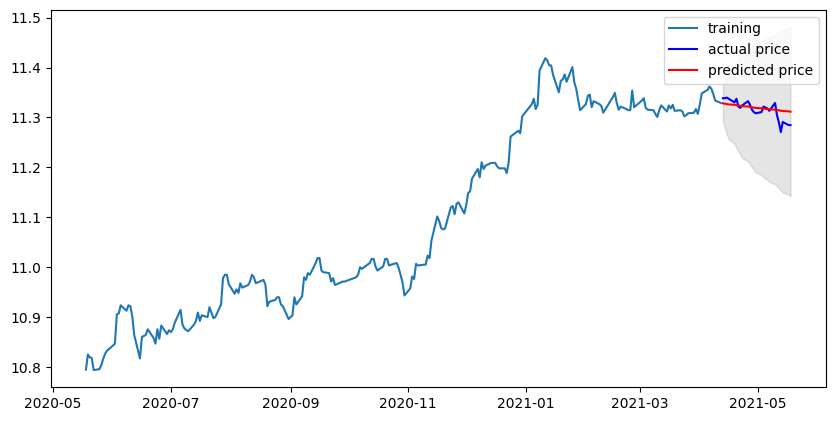

In [81]:
# Forecast 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) #- 95% conf

# make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index) #- 예측 결과의 하한 바운드 
upper_series = pd.Series(conf[:, 1], index=test_data.index) #- 예측 결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1533430.4832786121
MAE:  957.802482046241
RMSE:  1238.3176019416878
MAPE: 1.18%


# 주식 예측 함수 만들기 

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import os 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#- Time Series 생성
def load_data(filename):
    dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/'+filename
    df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
    name = filename.split('.')[0]
    print('-'*16,f'{name} 주식 시계열 - 전체','-'*16)
    print(df.head())
    ts = df['Close']
    print('-'*16,f'{name} 주식 시계열 - 종가','-'*16)
    print(ts.head())
    return ts

def augmented_dickey_fuller_test(timeseries):
    #- statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    #- adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() #- 이동평균
    rolstd = timeseries.rolling(window=window).std() #- 이동표준편차
    
    #- 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    
def preprocess_data(ts): 
    
    #- 결측치 처리
    ts = ts.interpolate(method='time') # 결측값 보간
    ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력
    plt.plot(ts)

    #- 로그 변환
    ts_log = np.log(ts)
    print(ts_log)

    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)

    # 정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

    # 시계열 분해(Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

    trend = decomposition.trend        # 추세(시간의 추이에 따라 나타나는 평균값 변화)
    seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid     # 원본(로그변환) - 추세 - 계절성

    # 원본 / 추세(Trend) / 계절성(Seaseonality) / 잔차(Residuals) 시각화 확인
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

    # 학습, 테스트 데이터셋 생성
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()

    # ACF, PACF 그려보기 -> p,q 구하기

    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

    # 차분 안정성 확인 -> d 구하기
    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)

    #2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)
    
    return ts_log, train_data, test_data 


def train_test_model(train_data,p=1,d=1,q=0):
    
    # Build and Train  Model
    model = ARIMA(train_data, order=(p,d,q)) # p, d, q 순서
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())

    fitted_m.plot_predict() # 훈련 결과 확인

    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

# 2. Google


---------------- GOOGLE 주식 시계열 - 전체 ----------------
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-09-08  1533.510010  1563.864990  1528.010010  1532.390015  1532.390015   
2020-09-09  1557.530029  1569.000000  1536.051025  1556.959961  1556.959961   
2020-09-10  1560.640015  1584.081055  1525.805054  1532.020020  1532.020020   
2020-09-11  1536.000000  1575.199951  1497.359985  1520.719971  1520.719971   
2020-09-14  1539.005005  1564.000000  1515.739990  1519.280029  1519.280029   

             Volume  
Date                 
2020-09-08  2610900  
2020-09-09  1774700  
2020-09-10  1618600  
2020-09-11  1597100  
2020-09-14  1696600  
---------------- GOOGLE 주식 시계열 - 종가 ----------------
Date
2020-09-08    1532.390015
2020-09-09    1556.959961
2020-09-10    1532.020020
2020-09-11    1520.719971
2020-09-14    1519.280029
Name: Close, dtype: float64
Date
2020-09-08    7.33

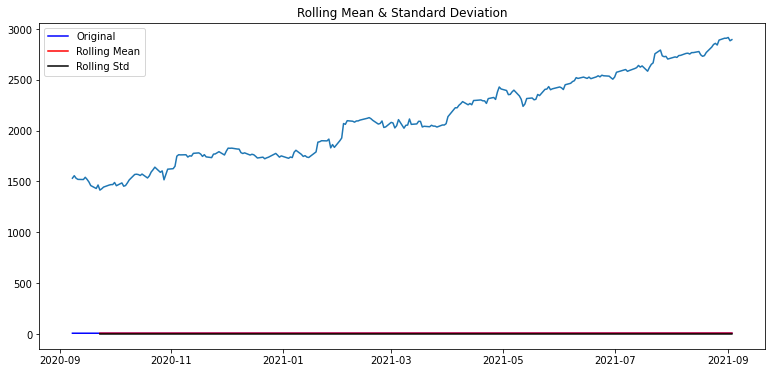

Results of Dickey-Fuller Test:
Test Statistic                  -0.460093
p-value                          0.899572
#Lags Used                       7.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -2.754986
p-value                          0.064997
#Lags Used                      15.000000
Number of Observations Used    205.000000
Critical Value (1%)             -3.462658
Critical Value (5%)             -2.875744
Critical Value (10%)            -2.574341
dtype: float64


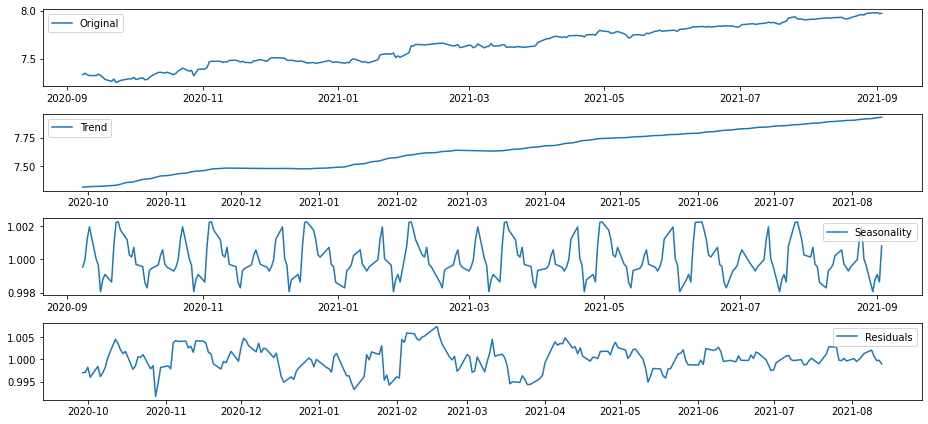

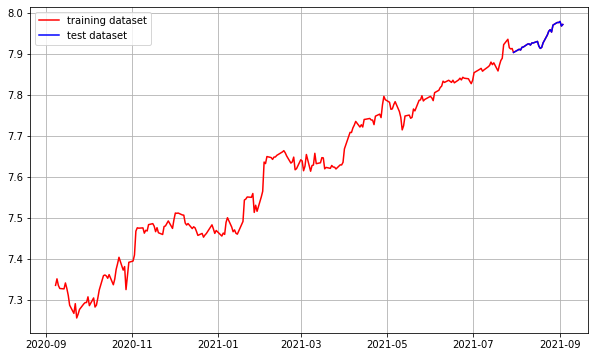

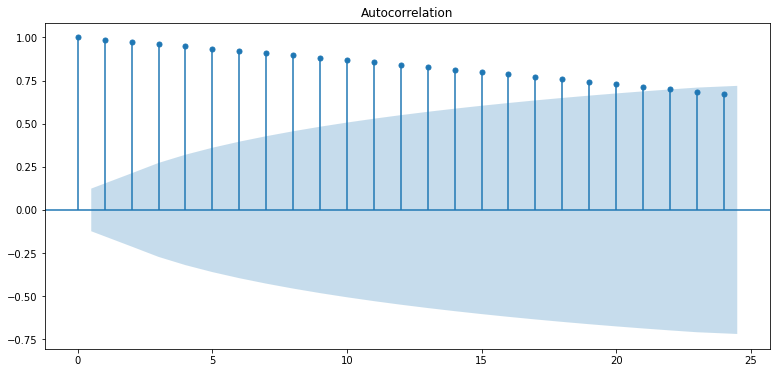

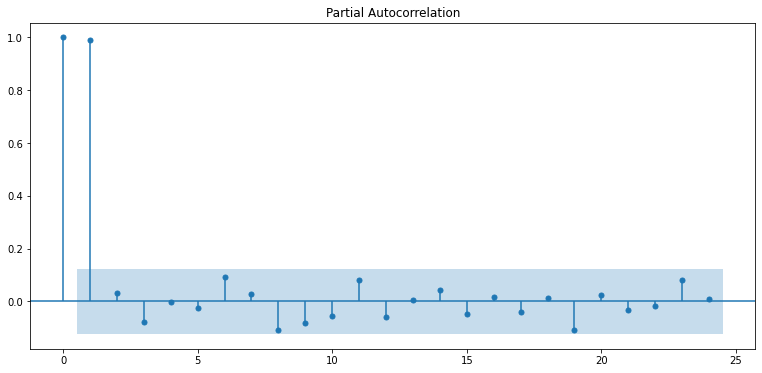

Results of Dickey-Fuller Test:
Test Statistic                -6.586295e+00
p-value                        7.300537e-09
#Lags Used                     6.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.930959e+00
p-value                        1.084448e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


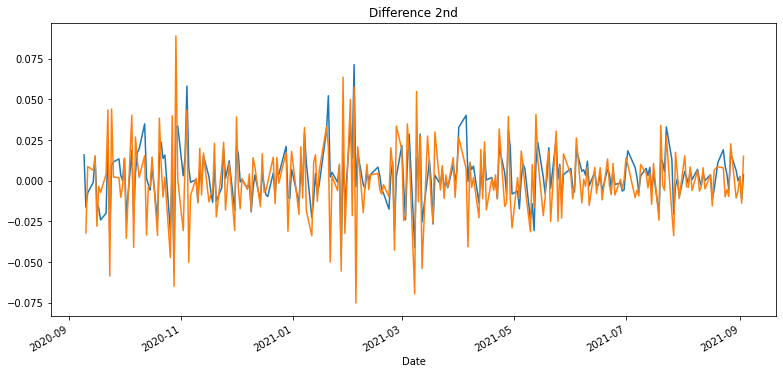

In [59]:
ts = load_data('GOOGLE.csv')
ts_log, train_data, test_data = preprocess_data(ts)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 603.369
Method:                       css-mle   S.D. of innovations              0.016
Date:                Mon, 06 Sep 2021   AIC                          -1200.738
Time:                        15:39:23   BIC                          -1190.503
Sample:                             1   HQIC                         -1196.606
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0026      0.001      2.464      0.014       0.001       0.005
ar.L1.D.Close    -0.0455      0.067     -0.683      0.495      -0.176       0.085
                                    Root

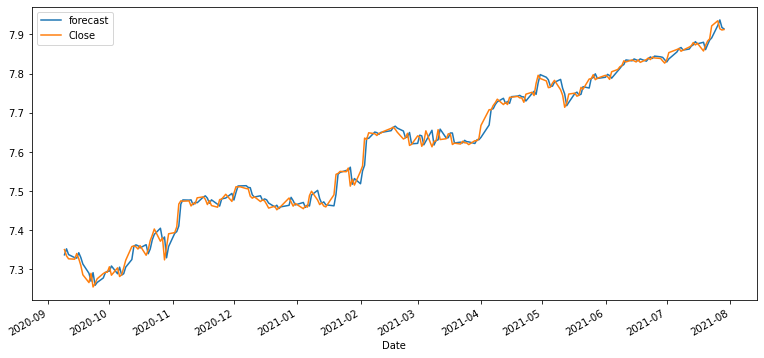

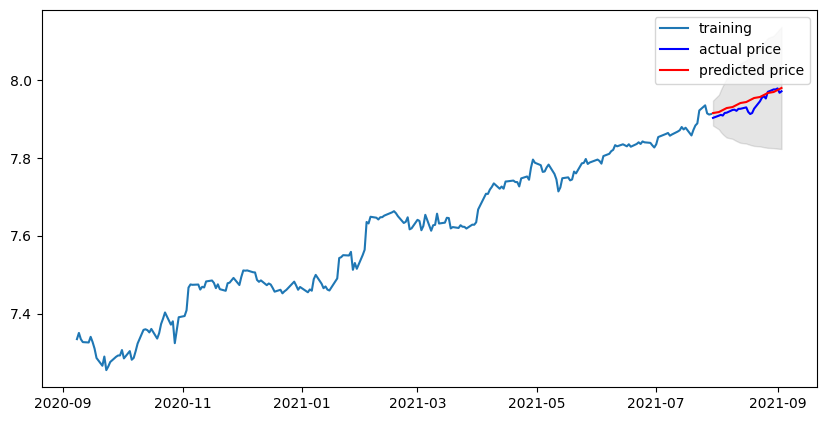

MSE:  1904.1269051311667
MAE:  35.83070718588424
RMSE:  43.63630260610042
MAPE: 1.29%


In [60]:
train_test_model(train_data,1,1,0)

# 3. Tesla


---------------- TESLA 주식 시계열 - 전체 ----------------
                  Open       High         Low       Close   Adj Close  \
Date                                                                    
2020-09-08  356.000000  368.73999  329.880005  330.209991  330.209991   
2020-09-09  356.600006  369.00000  341.510010  366.279999  366.279999   
2020-09-10  386.209991  398.98999  360.559998  371.339996  371.339996   
2020-09-11  381.940002  382.50000  360.500000  372.720001  372.720001   
2020-09-14  380.950012  420.00000  373.299988  419.619995  419.619995   

               Volume  
Date                   
2020-09-08  115465700  
2020-09-09   79465800  
2020-09-10   84930600  
2020-09-11   60717500  
2020-09-14   83020600  
---------------- TESLA 주식 시계열 - 종가 ----------------
Date
2020-09-08    330.209991
2020-09-09    366.279999
2020-09-10    371.339996
2020-09-11    372.720001
2020-09-14    419.619995
Name: Close, dtype: float64
Date
2020-09-08    5.799729
2020-09-09    5.903398
2020-09

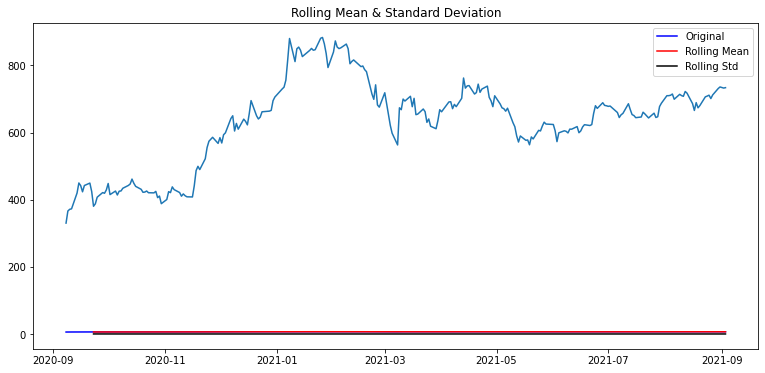

Results of Dickey-Fuller Test:
Test Statistic                  -2.710861
p-value                          0.072178
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.105330
p-value                          0.000014
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


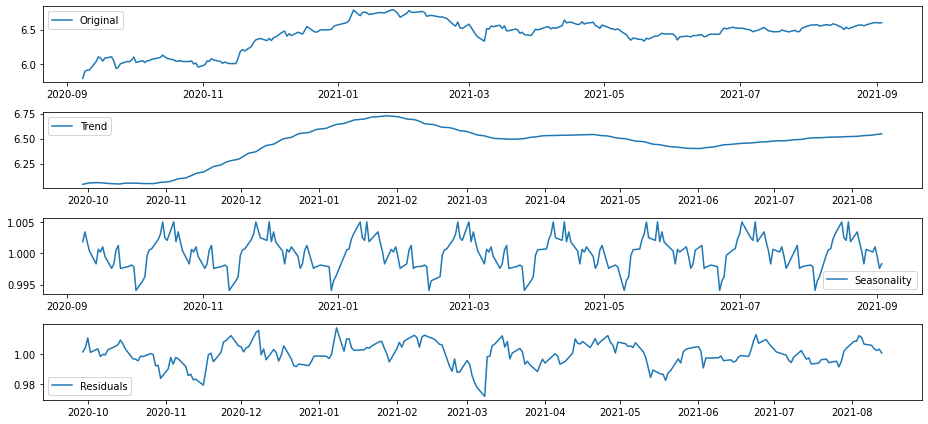

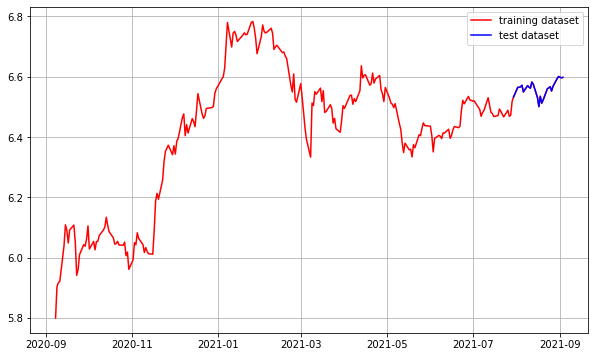

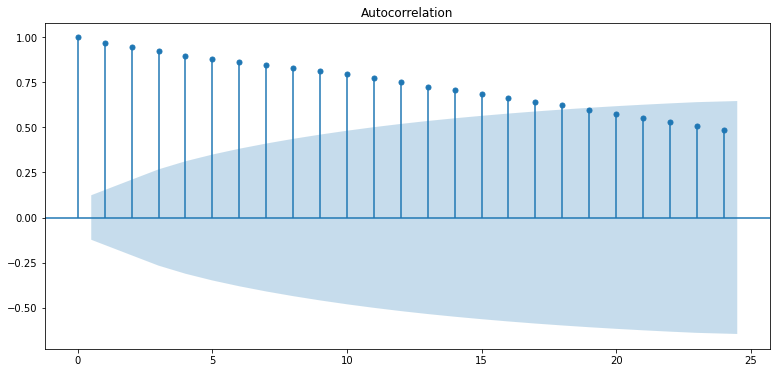

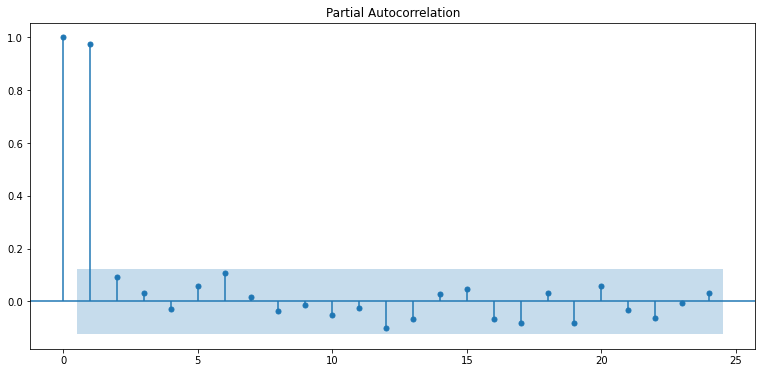

Results of Dickey-Fuller Test:
Test Statistic                -1.637067e+01
p-value                        2.812385e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.102374e+01
p-value                        5.898900e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


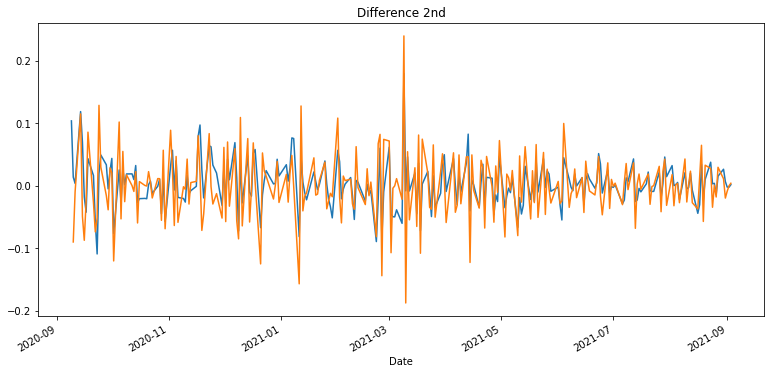

In [61]:
ts = load_data('TESLA.csv')
ts_log, train_data, test_data = preprocess_data(ts)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 414.678
Method:                       css-mle   S.D. of innovations              0.038
Date:                Mon, 06 Sep 2021   AIC                           -823.357
Time:                        15:39:35   BIC                           -813.122
Sample:                             1   HQIC                          -819.225
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.002      1.291      0.197      -0.002       0.008
ar.L1.D.Close    -0.0279      0.068     -0.410      0.681      -0.161       0.105
                                    Root

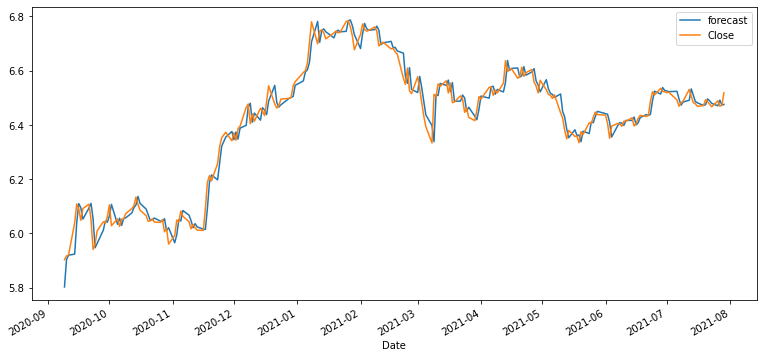

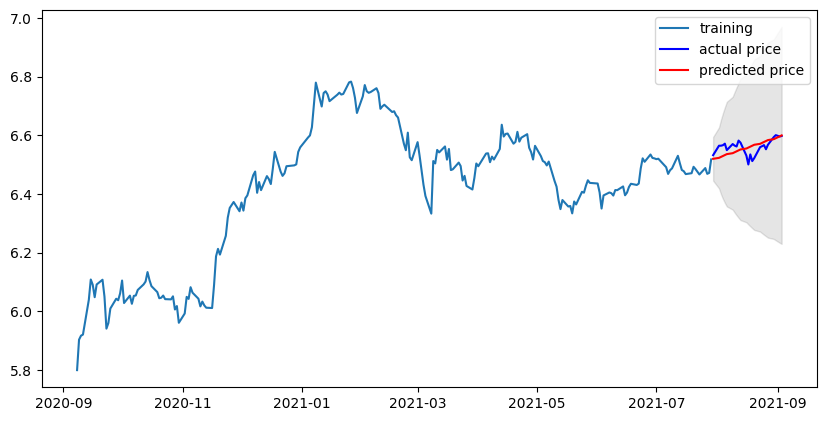

MSE:  389.4746714952593
MAE:  16.620260166409174
RMSE:  19.735112654739503
MAPE: 2.38%


In [62]:
train_test_model(train_data,1,1,0)

# 4. Naver


---------------- NAVER 주식 시계열 - 전체 ----------------
                Open      High       Low     Close     Adj Close   Volume
Date                                                                     
2020-09-07  325500.0  325500.0  313500.0  314500.0  314050.06250  1308247
2020-09-08  316000.0  318000.0  305500.0  311000.0  310555.06250   989171
2020-09-09  303000.0  307000.0  300000.0  304500.0  304064.37500   925825
2020-09-10  309000.0  311000.0  305000.0  307500.0  307060.09375   834946
2020-09-11  302500.0  307000.0  301000.0  306000.0  305562.21875   517023
---------------- NAVER 주식 시계열 - 종가 ----------------
Date
2020-09-07    314500.0
2020-09-08    311000.0
2020-09-09    304500.0
2020-09-10    307500.0
2020-09-11    306000.0
Name: Close, dtype: float64
Date
2020-09-07    12.658739
2020-09-08    12.647548
2020-09-09    12.626426
2020-09-10    12.636230
2020-09-11    12.631340
                ...    
2021-08-31    12.992255
2021-09-01    13.005830
2021-09-02    13.000196
2021-09-0

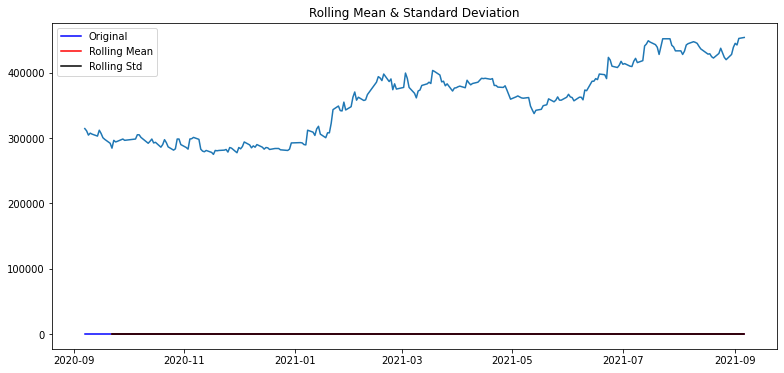

Results of Dickey-Fuller Test:
Test Statistic                  -0.350788
p-value                          0.917997
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.629220e+00
p-value                        5.771542e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


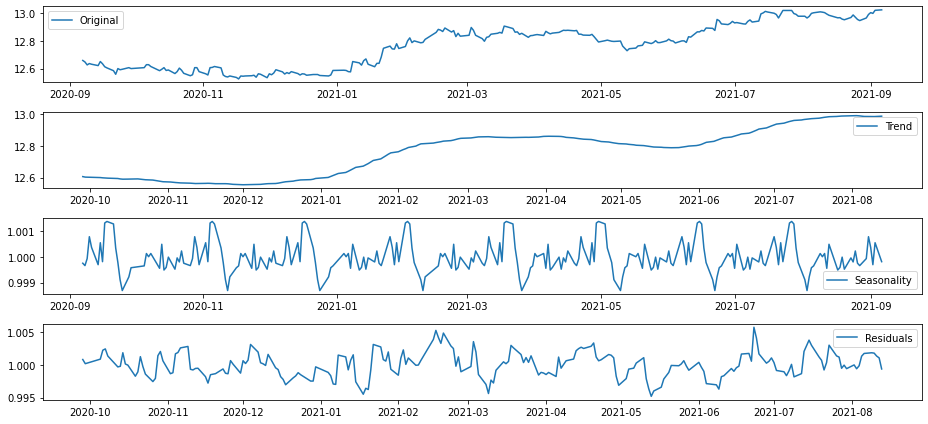

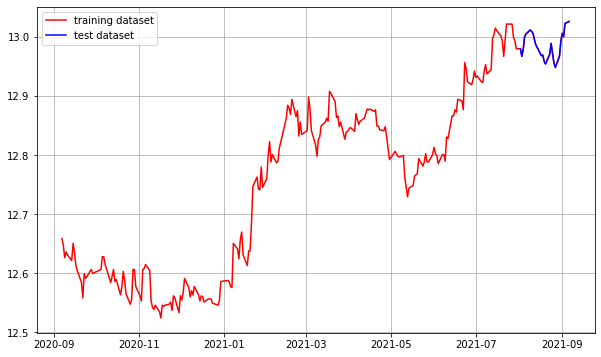

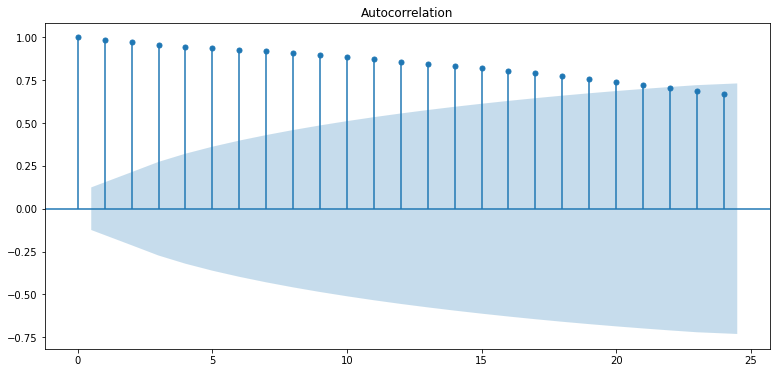

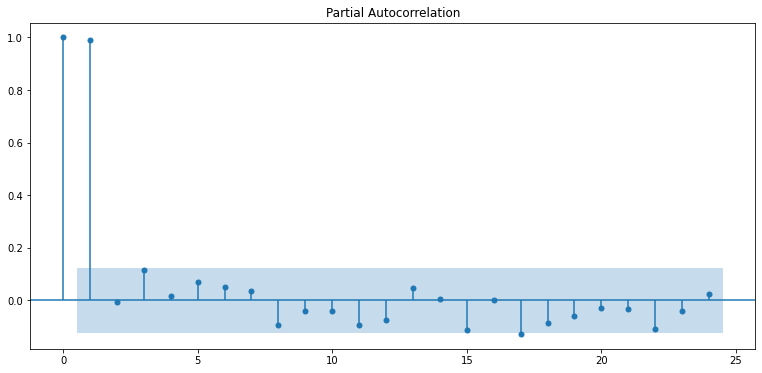

Results of Dickey-Fuller Test:
Test Statistic                -1.269325e+01
p-value                        1.120256e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.945369e+00
p-value                        1.000415e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


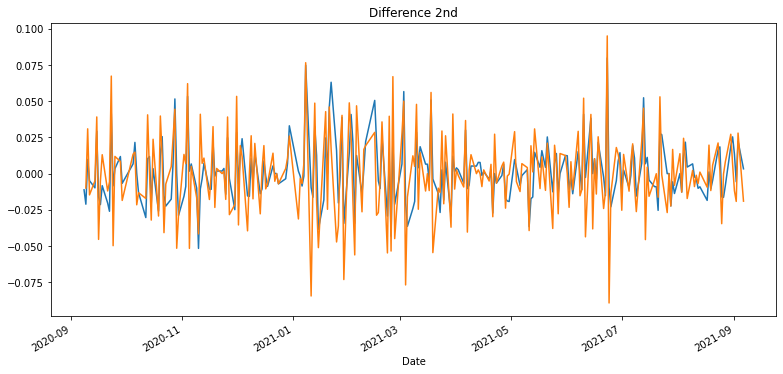

In [63]:
ts = load_data('NAVER.csv')
ts_log, train_data, test_data = preprocess_data(ts)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 545.646
Method:                       css-mle   S.D. of innovations              0.021
Date:                Mon, 06 Sep 2021   AIC                          -1085.292
Time:                        15:40:06   BIC                          -1075.084
Sample:                             1   HQIC                         -1081.170
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.072      0.284      -0.001       0.004
ar.L1.D.Close    -0.0285      0.067     -0.426      0.670      -0.160       0.103
                                    Root

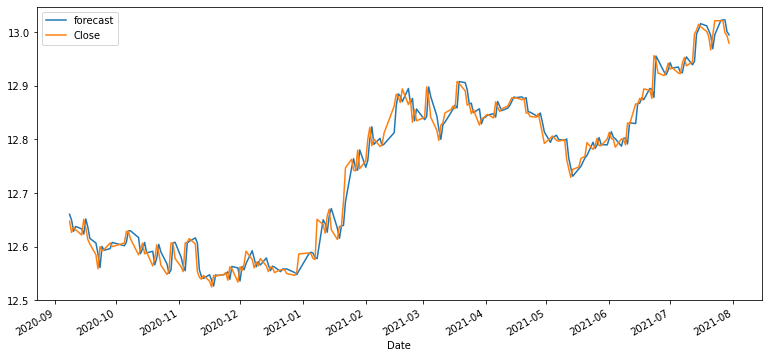

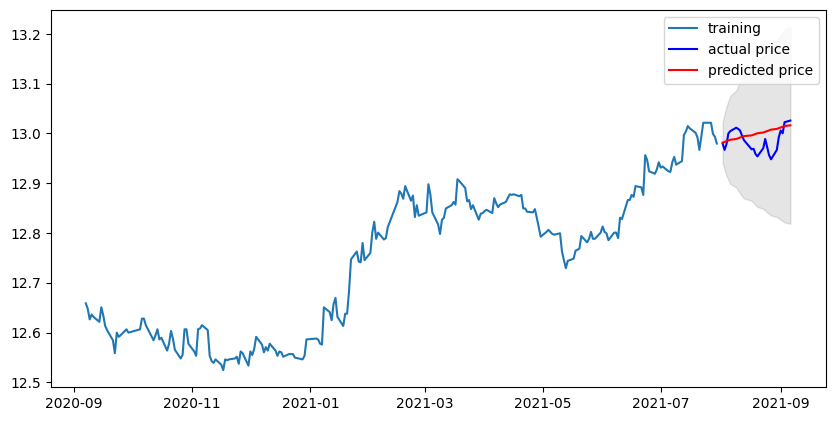

MSE:  136749736.94864967
MAE:  9598.722259287522
RMSE:  11694.004316257528
MAPE: 2.23%


In [64]:
train_test_model(train_data,1,1,0)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  221
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 488.063
Method:                       css-mle   S.D. of innovations              0.027
Date:                Mon, 06 Sep 2021   AIC                           -970.126
Time:                        15:40:20   BIC                           -959.931
Sample:                             2   HQIC                          -966.009
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1.37e-05      0.001      0.011      0.991      -0.002       0.002
ar.L1.D2.Close    -0.4486      0.060     -7.492      0.000      -0.566      -0.331
                                    

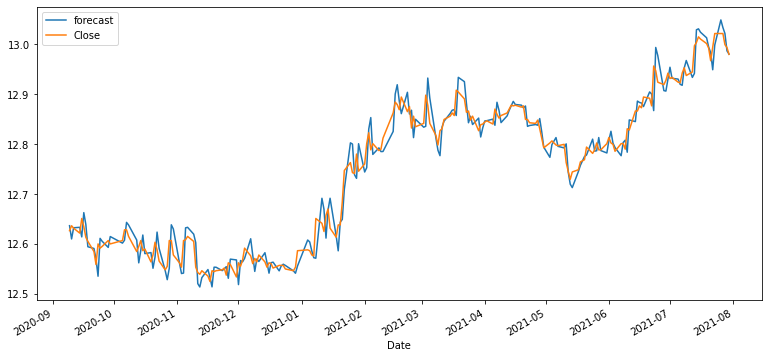

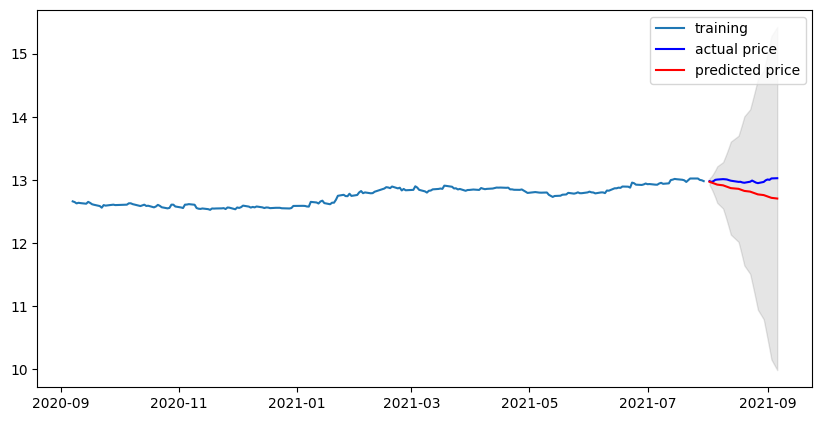

MSE:  4570372366.570094
MAE:  59507.98870562399
RMSE:  67604.52918680888
MAPE: 13.59%


In [65]:
train_test_model(train_data,1,2,0)

# 5. 평가지표 살펴보기
## 1. MSE (Mean Squared Error)
    ∑( 예측값 – 실제값）² / n

- 실제값과 예측값의 차이를 제곱해 평균화합니다.
- 예측값과 실제값 차이의 면적의 합입니다.
- 제곱을 하기 때문에 이상치에 민감합니다. 


## 2. MAE (Mean Absolute Error)
    ∑( |예측값 – 실제값| ) / n
- 실제값과 예측값의 차이를 절대값으로 변환해 평균화합니다. 
- MAE 는 에러에 절대값을 취하기 때문에 에러의 크기가 그대로 반영됩니다. 
- MSE 보다 이상치에 덜 민감하기 때문에 이상치가 많을 때 적용합니다. 

## 3. RMSE (Root Mean Squared Error)
    √ ( ∑( 실제값 - 예측값）² / n )
- MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 루트를 씌운 RMSE 값을 씁니다. 
- 오류 지표를 실제 값과 유사한 단위로 다시 변환하기 때문에 해석이 다소 용이해집니다.

## 4. MAPE (Mean Absolute Percentage Error)
    ( ∑( | 실제값 - 예측값 | / 실제값））／ｎ * 100
- MAE를 퍼센트로 변환합니다.
- 모델에 대한 편향이 존재합니다. 
- MAE 와 같은 단점이 나타납니다. 



# 6. 결과 비교해석

### 삼성전자 주식 예측
```
p, d, q = 1, 1, 0
MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


p, d, q = 0, 1, 1
MSE:  22088457.65325718

MAE:  3791.4564135901687
RMSE:  4699.835917695125
MAPE: 4.68%


p, d, q = 1, 1, 1
MSE:  22124900.384517975
MAE:  3795.2033017645904
RMSE:  4703.7113415385065
MAPE: 4.68%


p, d, q = 1, 0, 0
MSE:  1533430.4832786121
MAE:  957.802482046241
RMSE:  1238.3176019416878
MAPE: 1.18%
```

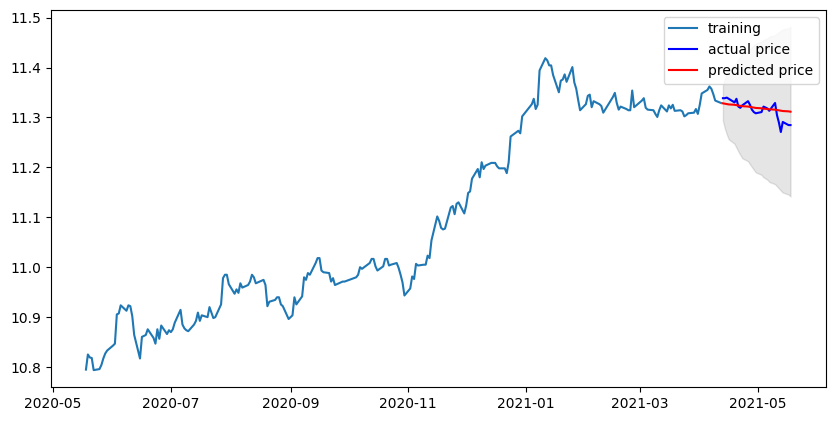

### Google 주식 예측
```
p, d, q = 1, 2, 0

MSE:  14089.87868148664
MAE:  89.21742986501229
RMSE:  118.70079478034947
MAPE: 3.12%


p, d, q = 1, 1, 0

MSE:  1904.1269051311667
MAE:  35.83070718588424
RMSE:  43.63630260610042
MAPE: 1.29%
```

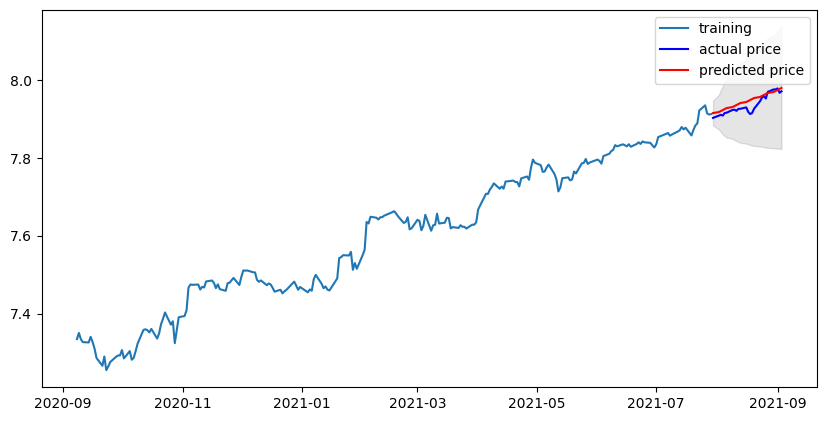

### Tesla 주식 예측
```
p, d, q = 1, 1, 0
MSE:  389.4746714952593
MAE:  16.620260166409174
RMSE:  19.735112654739503
MAPE: 2.38%
```
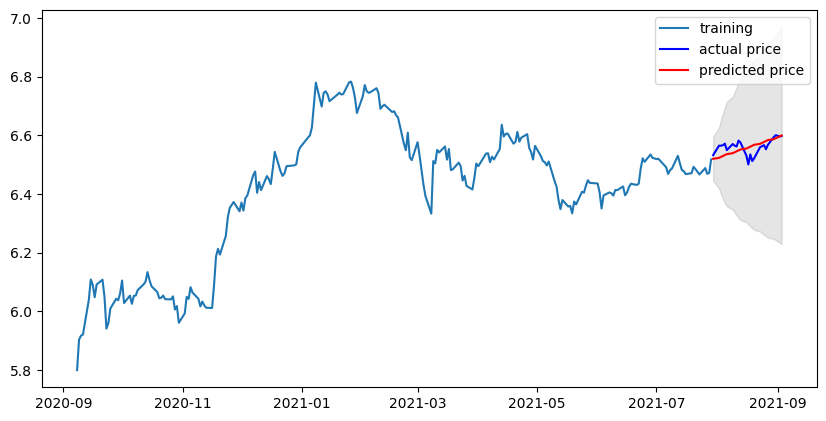

### Naver 주식 예측 
```

p, d, q = 1, 2, 0
MSE:  4570372366.570094
MAE:  59507.98870562399
RMSE:  67604.52918680888
MAPE: 13.59%


p, d, q = 1, 1, 0
MSE:  136749736.94864967
MAE:  9598.722259287522
RMSE:  11694.004316257528
MAPE: 2.23%
```
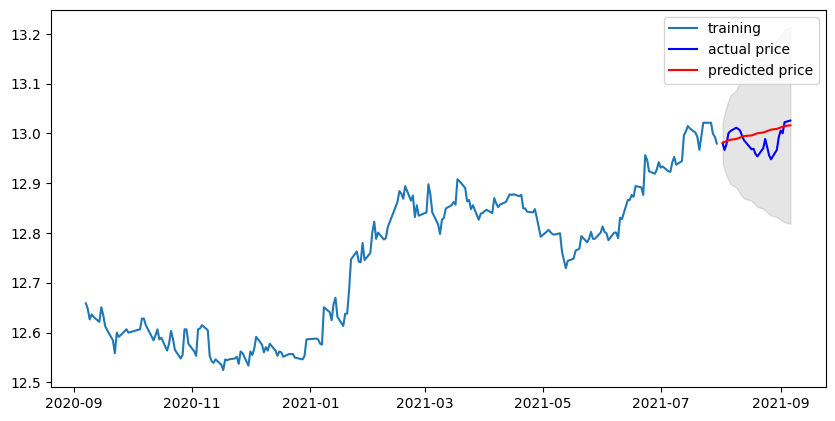

- ACF, PACF, 차분안정성을 고려하여 ARIMA 모델의 모수(p,d,q)를 조합하여 비교해본 결과, 구글, 테슬라, 네이버 모두 p, d, q = 1, 1, 0 일때 예측성능이 좋았습니다. 반면, 삼성전자의 경우 차분을 적용하지 않았을 때(d=0) 성능이 좋았습니다. 
 
- Naver 주식예측의 경우에는 d=2 인 경우보다 d=1 일때의 p-value가 더 낮았기 때문에, d = 2로 학습을 시킨 경우 MAPE가 13.59%로 d=1 에서 MAPE가 2.23% 보다 좋지 않은 성능을 보이는 사실을 납득할 수 있었습니다.

- 하지만 삼성전자의 경우 차분을 적용하지 않았을 때의 p-value는 0.590149, 차분을 한번 적용했을 때의 p-value는 2.183738e-28 였기 때문에 차분을 적용하지 않았을 경우 성능이 잘 나오는 현상이 잘 이해가 되지 않았습니다.

- 고민 결과, p-value는 시계열 데이터의 안정성을 검증하여 이후 예측의 신뢰성의 근거가 되는 역할을 하기 때문에, 아무리 성능이 좋게 나왔다 하더라도 p-value가 0.05 보다 큰 경우 유의미한 결과라고 볼 수 없다고 판단됩니다. 때문에 삼성전자의 경우 차분을 시행하지 않아 p-value가 0.59 일때 성능지표가 가장 좋게 나왔다고 하더라도 신뢰할 수 있는 유의미한 결과라고 할 수 없을 것입니다.

- 비교적 간단한 통계모델인 ARIMA를 통해 주식예측을 해보았는데, 강화학습, LSTM 등 다양한 방법을 통한 주식예측도 재밌을 것 같네요 ~ 

- 첫 주식예측이라 노드에 나온 기본적인 과정을 (헐레벌떡) 따라가기만 했는데, 다음번에는 조금 더 전처리와 모델에 신경을 써서 어떻게 성능을 높일 수 있을 지 고민해보고 싶습니다.

---
참고 )
p-value 는 귀무가설이 맞다고 가정할 때 얻은 결과보다 극단적인 결과가 실제로 관측될 확률로서, 과학자들은 0.05 ~ 0.005 의 P 값을 '제안적 증거' 로 표현하고 0.005 이하의 P값에서 유의마하다는 표현을 사용할 것으로 권고한다. 
